In [1]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import mlfoundry as mlf

from sklearn.metrics import mean_absolute_error, mean_squared_error

## Data preprocessing

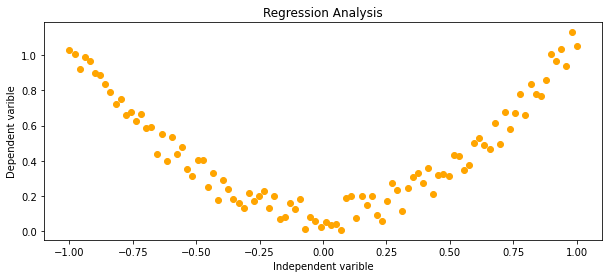

In [2]:
x = torch.unsqueeze(torch.linspace(-1, 1, 100), dim=1)  # x data (tensor), shape=(100, 1)
y = x.pow(2) + 0.2*torch.rand(x.size())                 # noisy y data (tensor), shape=(100, 1)

# torch can only train on Variable, so convert them to Variable
x, y = Variable(x), Variable(y)

x_test = torch.rand(100,1)  
y_test = x.pow(2)        

# view data
plt.figure(figsize=(10,4))
plt.scatter(x.data.numpy(), y.data.numpy(), color = "orange")
plt.title('Regression Analysis')
plt.xlabel('Independent varible')
plt.ylabel('Dependent varible')
plt.show()

## Pytorch Model

In [3]:
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x


loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

## Training loop

In [4]:
def train(epoch, lr, hidden, run):
        net = Net(n_feature=1, n_hidden=hidden, n_output=1)     # define the network
        optimizer = torch.optim.SGD(net.parameters(), lr=lr)
        
        fig, ax = plt.subplots(figsize=(12,7))

        for t in range(epoch):

                prediction = net(x)     # input x and predict based on x

                loss = loss_func(prediction, y)     # must be (1. nn output, 2. target)

                optimizer.zero_grad()   # clear gradients for next train
                loss.backward()         # backpropagation, compute gradients
                optimizer.step()        # apply gradients
                
                y_test_numpy = y_test.detach().numpy()
                y_test_numpy = np.reshape(y_test_numpy, y_test_numpy.shape[0])

                y_test_hat = net(x_test).detach().numpy()
                y_test_hat = np.reshape(y_test_hat, y_test_hat.shape[0])

                y_test_hat_2 = net(x_test).detach().numpy()
                y_test_hat_2 = np.reshape(y_test_hat_2, y_test_hat_2.shape[0])
                
                mae = mean_absolute_error(y_test_numpy, y_test_hat)
                mse = mean_squared_error(y_test_numpy, y_test_hat)
                
                run.log_metrics({"mean absolute error":mae, "mean squared error":mse})

                # plot and show learning process
                plt.cla()
                ax.set_title('Regression Analysis', fontsize=35)
                ax.set_xlabel('Independent variable', fontsize=24)
                ax.set_ylabel('Dependent variable', fontsize=24)
                ax.set_xlim(-1.05, 1.5)
                ax.set_ylim(-0.25, 1.25)
                ax.scatter(x.data.numpy(), y.data.numpy(), color = "orange")
                ax.plot(x.data.numpy(), prediction.data.numpy(), 'g-', lw=3)
                ax.text(1.0, 0.1, 'Step = %d' % t, fontdict={'size': 24, 'color':  'red'})
                ax.text(1.0, 0, 'Loss = %.4f' % loss.data.numpy(),
                        fontdict={'size': 24, 'color':  'red'})

                fig.canvas.draw()  
                image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
                image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        return net

## Creating mlf run

In [5]:
mlf_api = mlf.get_client()
mlf_run = mlf_api.create_run(project_name='pytorch-project')
mlf_run_2 = mlf_api.create_run(project_name='pytorch-project')

## Training

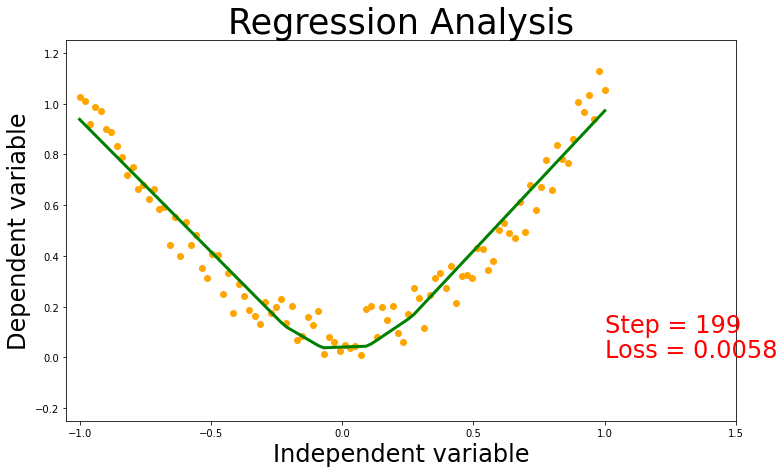

In [6]:
net1 = train(epoch=200, lr=0.2, hidden=10, run=mlf_run)

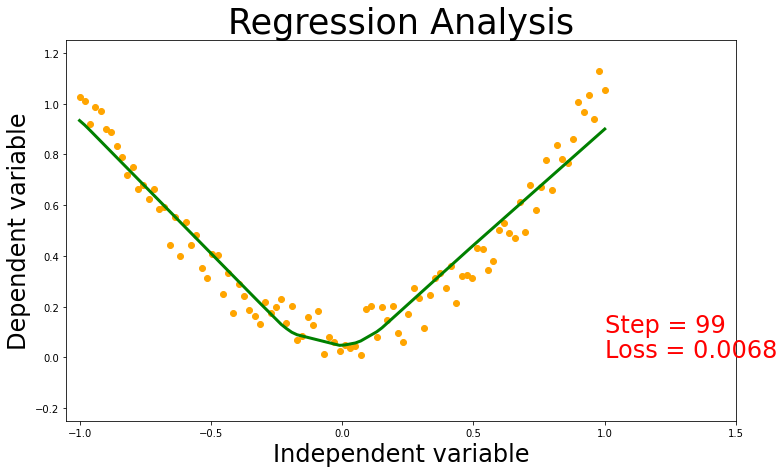

In [7]:
net2 = train(epoch=100, lr=0.2, hidden=15, run=mlf_run_2)

In [8]:
y_test_numpy = y_test.detach().numpy()
y_test_numpy = np.reshape(y_test_numpy, y_test_numpy.shape[0])

y_test_hat = net1(x_test).detach().numpy()
y_test_hat = np.reshape(y_test_hat, y_test_hat.shape[0])

y_test_hat_2 = net1(x_test).detach().numpy()
y_test_hat_2 = np.reshape(y_test_hat_2, y_test_hat_2.shape[0])

## Logging params

In [9]:
params = {
    "epoch":200, "lr":0.2, "hidden":10
}
mlf_run.log_params(params)

params = {
    "epoch":100, "lr":0.2, "hidden":15
}
mlf_run_2.log_params(params)


## log_dataset_stats

In [13]:
import shap

X_test = pd.DataFrame(x_test.detach().numpy(), columns=["0"])

X_test_df = X_test.copy()
X_test_df['targets'] = y_test[:,0]
X_test_df['predictions'] = y_test_hat

# shap value computation
shap_values = shap.DeepExplainer(net1, x)
shap_values = shap_values.shap_values(x_test)

mlf_run.log_dataset_stats(
    X_test_df, 
    data_slice=mlf.DataSlice.TEST,
    data_schema=mlf.Schema(
        feature_column_names=["0"],
        prediction_column_name="predictions",
        actual_column_name="targets"
    ),
    shap_values=shap_values,
    model_type=mlf.ModelType.REGRESSION,
)

X_test_df = X_test.copy()
X_test_df['targets'] = y_test[:,0]
X_test_df['predictions'] = y_test_hat_2

# shap value computation
shap_values = shap.DeepExplainer(net2, x)
shap_values = shap_values.shap_values(x_test)


mlf_run_2.log_dataset_stats(
    X_test_df, 
    data_slice=mlf.DataSlice.TEST,
    data_schema=mlf.Schema(
        feature_column_names=["0"],
        prediction_column_name="predictions",
        actual_column_name="targets"
    ),
    model_type=mlf.ModelType.REGRESSION,
    shap_values=shap_values
)

WARN: Missing config
